# Solar Power Prediction — Final Project Notebook

Author: Saiful Islam Mahin

**Abstract:** This notebook loads a solar dataset, performs cleaning and exploratory data analysis (EDA), trains and compares multiple regression models (Linear Regression and Random Forest), evaluates them, examines feature importance, and saves the final model.

In [17]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import joblib
import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
sns.set_style('darkgrid')


## 1) Load dataset

Update the path below if your dataset is located elsewhere. The original notebook used `data/solardataset/solardatset.csv`.

In [18]:
# Load dataset - update path if necessary
csv_path = 'solardatset.csv'  # change to your local path if needed
try:
    df = pd.read_csv(csv_path)
except Exception as e:
    print('Could not load from kaggle path, trying uploaded path...')
    csv_path = '/solardatset.csv'  # alternative common location
    df = pd.read_csv(csv_path)

print('Dataset shape:', df.shape)
df.head()

Could not load from kaggle path, trying uploaded path...
Dataset shape: (4213, 21)


,temperature_2_m_above_gnd,relative_humidity_2_m_above_gnd,mean_sea_level_pressure_MSL,total_precipitation_sfc,snowfall_amount_sfc,total_cloud_cover_sfc,high_cloud_cover_high_cld_lay,medium_cloud_cover_mid_cld_lay,low_cloud_cover_low_cld_lay,shortwave_radiation_backwards_sfc,...,wind_direction_10_m_above_gnd,wind_speed_80_m_above_gnd,wind_direction_80_m_above_gnd,wind_speed_900_mb,wind_direction_900_mb,wind_gust_10_m_above_gnd,angle_of_incidence,zenith,azimuth,generated_power_kw
0,2.17,31,1035.0,0.0,0.0,0.0,0,0,0,0.00,...,312.71,9.36,22.62,6.62,337.62,24.48,58.753108,83.237322,128.33543,454.10095
1,2.31,27,1035.1,0.0,0.0,0.0,0,0,0,1.78,...,294.78,5.99,32.74,4.61,321.34,21.96,45.408585,75.143041,139.65530,1411.99940
2,3.65,33,1035.4,0.0,0.0,0.0,0,0,0,108.58,...,270.00,3.89,56.31,3.76,286.70,14.04,32.848282,68.820648,152.53769,2214.84930
3,5.82,30,1035.4,0.0,0.0,0.0,0,0,0,258.10,...,323.13,3.55,23.96,3.08,339.44,19.80,22.699288,64.883536,166.90159,2527.60920
4,7.73,27,1034.4,0.0,0.0,0.0,0,0,0,375.58,...,10.01,6.76,25.20,6.62,22.38,16.56,19.199908,63.795208,182.13526,2640.20340


### Inspect columns, dtypes and missing values

In [19]:
# Columns and datatypes
print('Columns:', df.columns.tolist())
print('\nData types:\n', df.dtypes)
print('\nMissing values per column:\n', df.isnull().sum())

Columns: ['temperature_2_m_above_gnd', 'relative_humidity_2_m_above_gnd', 'mean_sea_level_pressure_MSL', 'total_precipitation_sfc', 'snowfall_amount_sfc', 'total_cloud_cover_sfc', 'high_cloud_cover_high_cld_lay', 'medium_cloud_cover_mid_cld_lay', 'low_cloud_cover_low_cld_lay', 'shortwave_radiation_backwards_sfc', 'wind_speed_10_m_above_gnd', 'wind_direction_10_m_above_gnd', 'wind_speed_80_m_above_gnd', 'wind_direction_80_m_above_gnd', 'wind_speed_900_mb', 'wind_direction_900_mb', 'wind_gust_10_m_above_gnd', 'angle_of_incidence', 'zenith', 'azimuth', 'generated_power_kw']

Data types:
 temperature_2_m_above_gnd            float64
relative_humidity_2_m_above_gnd        int64
mean_sea_level_pressure_MSL          float64
total_precipitation_sfc              float64
snowfall_amount_sfc                  float64
total_cloud_cover_sfc                float64
high_cloud_cover_high_cld_lay          int64
medium_cloud_cover_mid_cld_lay         int64
low_cloud_cover_low_cld_lay            int64
sho

## 2) Data cleaning

Actions:
- Rename columns for readability (optional)
- Handle missing values (drop or impute)
- Ensure target column `generated_power_kw` exists


In [20]:
# Standardize column names (optional): make them shorter & python-friendly
# We'll keep original names but create a cleaned-copy mapping if desired.
clean_cols = {c: c.strip() for c in df.columns}
df.rename(columns=clean_cols, inplace=True)

# Confirm target exists
target = 'generated_power_kw'
if target not in df.columns:
    raise KeyError(f"Target column '{target}' not found. Available columns: {df.columns.tolist()}")

# Drop rows with missing target, then decide on other missing values
df = df.dropna(subset=[target])

# For remaining missing values, simple strategy: forward-fill then drop remaining
df.fillna(method='ffill', inplace=True)
df.dropna(inplace=True)

print('After cleaning, shape:', df.shape)

After cleaning, shape: (4213, 21)


## 3) Exploratory Data Analysis (EDA)

Show distributions and correlation heatmap. Use plots to support conclusions.

,count,mean,std,min,25%,50%,75%,max
temperature_2_m_above_gnd,4213.0,15.068111,8.853677,-5.350000,8.390000,14.750000,21.290000,34.90000
relative_humidity_2_m_above_gnd,4213.0,51.361025,23.525864,7.000000,32.000000,48.000000,70.000000,100.00000
mean_sea_level_pressure_MSL,4213.0,1019.337812,7.022867,997.500000,1014.500000,1018.100000,1023.600000,1046.80000
total_precipitation_sfc,4213.0,0.031759,0.170212,0.000000,0.000000,0.000000,0.000000,3.20000
snowfall_amount_sfc,4213.0,0.002808,0.038015,0.000000,0.000000,0.000000,0.000000,1.68000
total_cloud_cover_sfc,4213.0,34.056990,42.843638,0.000000,0.000000,8.700000,100.000000,100.00000
high_cloud_cover_high_cld_lay,4213.0,14.458818,30.711707,0.000000,0.000000,0.000000,9.000000,100.00000
medium_cloud_cover_mid_cld_lay,4213.0,20.023499,36.387948,0.000000,0.000000,0.000000,10.000000,100.00000
low_cloud_cover_low_cld_lay,4213.0,21.373368,38.013885,0.000000,0.000000,0.000000,10.000000,100.00000
shortwave_radiation_backwards_sfc,4213.0,387.759036,278.459293,0.000000,142.400000,381.810000,599.860000,952.30000


<Figure size 1200x800 with 0 Axes>

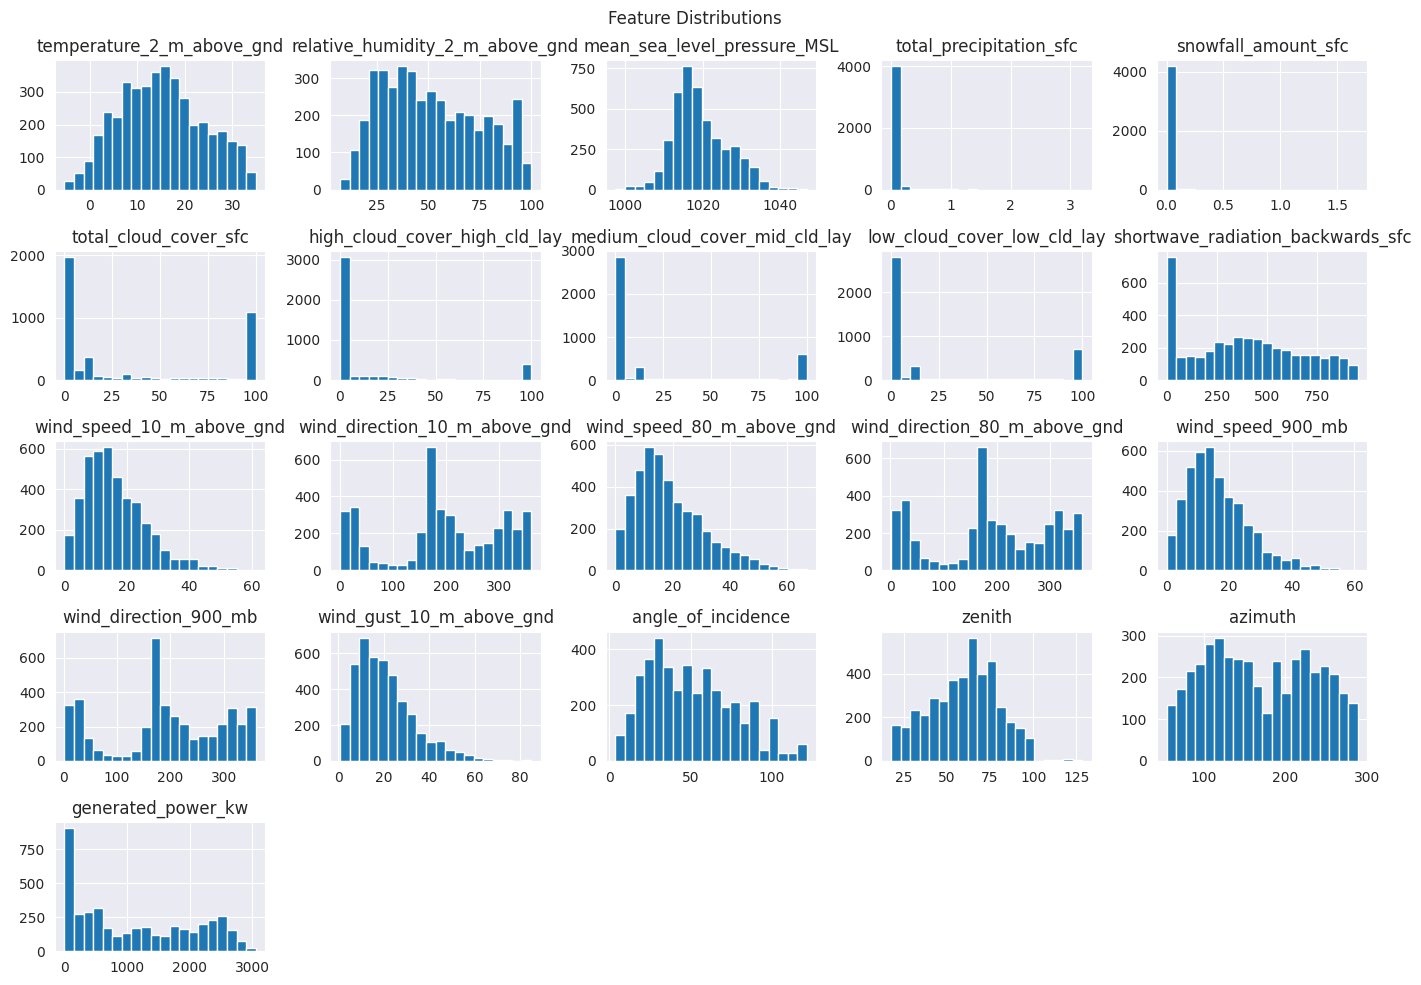

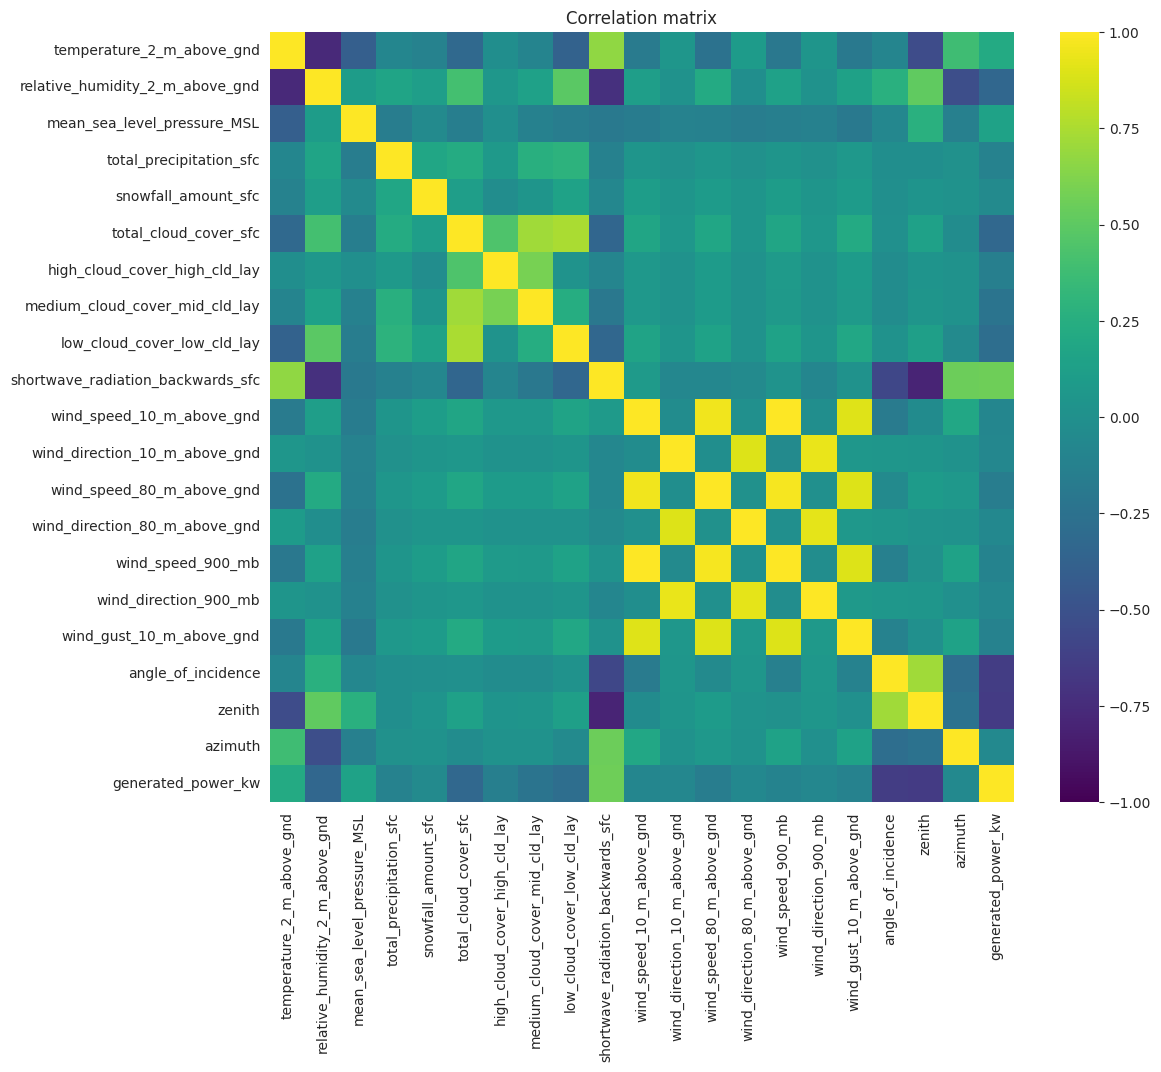


Top correlations with target:


,generated_power_kw
generated_power_kw,1.000000
zenith,0.649991
angle_of_incidence,0.646537
shortwave_radiation_backwards_sfc,0.556148
relative_humidity_2_m_above_gnd,0.336783
total_cloud_cover_sfc,0.334338
low_cloud_cover_low_cld_lay,0.288066
medium_cloud_cover_mid_cld_lay,0.227834
temperature_2_m_above_gnd,0.217280
wind_speed_80_m_above_gnd,0.157899


In [21]:
# Summary statistics
display(df.describe().T)

# Histograms (subset to avoid too many plots)
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
plt.figure(figsize=(12,8))
df[num_cols].hist(bins=20, figsize=(14,10))
plt.suptitle('Feature Distributions')
plt.tight_layout()
plt.show()

# Correlation heatmap (with target highlighted)
plt.figure(figsize=(12,10))
corr = df[num_cols].corr()
sns.heatmap(corr, annot=False, cmap='viridis', vmin=-1, vmax=1)
plt.title('Correlation matrix')
plt.show()

# Show top features correlated with target
corr_target = corr[target].abs().sort_values(ascending=False)
print('\nTop correlations with target:')
display(corr_target.head(10))

## 4) Prepare features (X) and target (y)

Split into train/test and scale features.

In [22]:
# Define X and y
X = df.drop(target, axis=1)
y = df[target]

# If any non-numeric columns exist, drop or encode them (we expect all numeric here)
non_numeric = X.select_dtypes(exclude=[np.number]).columns.tolist()
if non_numeric:
    print('Dropping non-numeric columns:', non_numeric)
    X = X.drop(columns=non_numeric)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features (recommended for many models)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print('Shapes:', X_train_scaled.shape, X_test_scaled.shape)

Shapes: (3370, 20) (843, 20)


## 5) Model training & comparison

We'll train Linear Regression and Random Forest and compare performance.

In [23]:
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42, n_jobs=-1)
}

results = []
trained_models = {}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append((name, mse, mae, r2))
    trained_models[name] = model

results_df = pd.DataFrame(results, columns=['Model','MSE','MAE','R2']).sort_values('R2', ascending=False)
results_df

,Model,MSE,MAE,R2
1,Random Forest,166149.720911,255.542733,0.818110
0,Linear Regression,257589.057694,391.792696,0.718008


## 6) Evaluation plots for best model

Plot Actual vs Predicted and residuals for the top model.

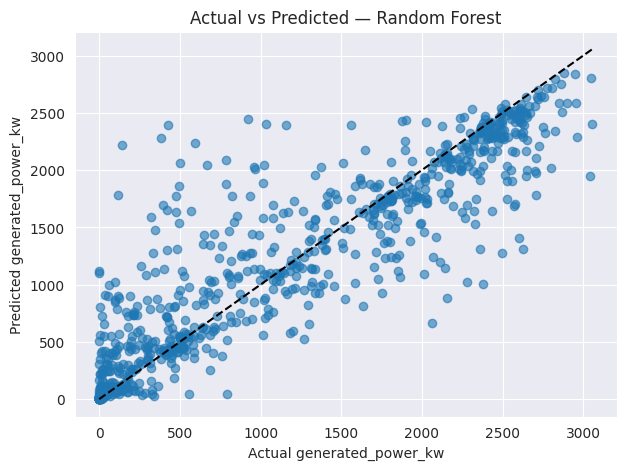

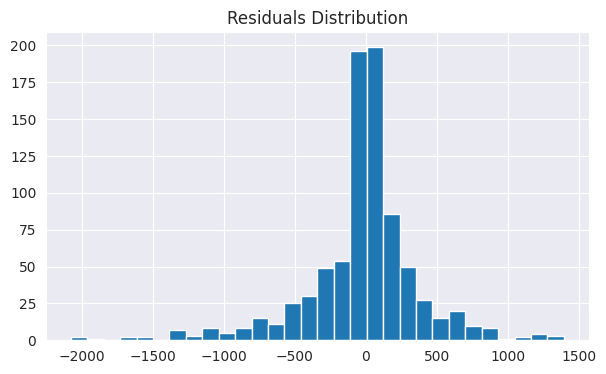

Best model: Random Forest
MSE: 166149.72091148
MAE: 255.5427325740411
R2: 0.8181102229401732


In [24]:
best_model_name = results_df.iloc[0]['Model']
best_model = trained_models[best_model_name]
y_pred_best = best_model.predict(X_test_scaled)

# Actual vs Predicted scatter
plt.figure(figsize=(7,5))
plt.scatter(y_test, y_pred_best, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel('Actual generated_power_kw')
plt.ylabel('Predicted generated_power_kw')
plt.title(f'Actual vs Predicted — {best_model_name}')
plt.show()

# Residuals distribution
residuals = y_test - y_pred_best
plt.figure(figsize=(7,4))
plt.hist(residuals, bins=30)
plt.title('Residuals Distribution')
plt.show()

# Print evaluation metrics
print('Best model:', best_model_name)
print('MSE:', mean_squared_error(y_test, y_pred_best))
print('MAE:', mean_absolute_error(y_test, y_pred_best))
print('R2:', r2_score(y_test, y_pred_best))

## 7) Feature importance (Random Forest)

If Random Forest is present, show feature importances. Otherwise show coefficients for Linear Regression.

,feature,importance
17,angle_of_incidence,0.346944
18,zenith,0.154182
5,total_cloud_cover_sfc,0.133312
19,azimuth,0.109929
9,shortwave_radiation_backwards_sfc,0.073307
2,mean_sea_level_pressure_MSL,0.028429
1,relative_humidity_2_m_above_gnd,0.025801
16,wind_gust_10_m_above_gnd,0.021229
0,temperature_2_m_above_gnd,0.020910
8,low_cloud_cover_low_cld_lay,0.011018


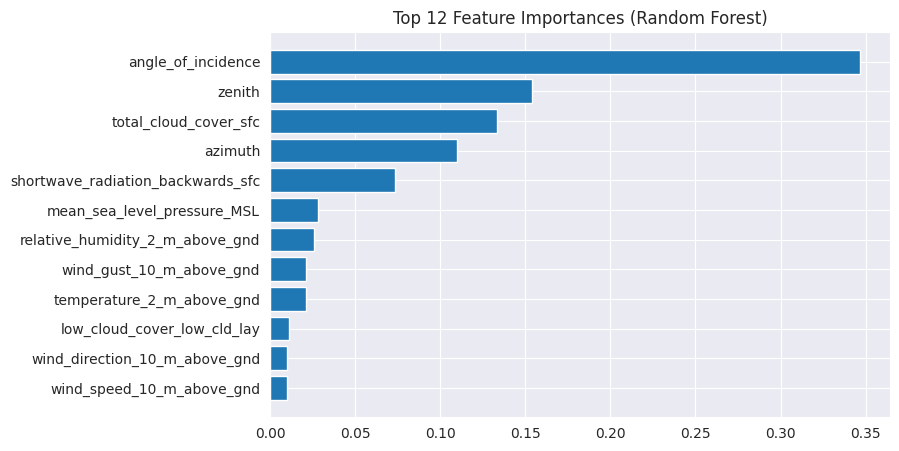

In [25]:
if 'Random Forest' in trained_models:
    rf = trained_models['Random Forest']
    try:
        importances = rf.feature_importances_
        feat_imp = pd.DataFrame({'feature': X.columns, 'importance': importances}).sort_values('importance', ascending=False)
        display(feat_imp.head(15))
        # Plot
        plt.figure(figsize=(8,5))
        plt.barh(feat_imp['feature'].head(12)[::-1], feat_imp['importance'].head(12)[::-1])
        plt.title('Top 12 Feature Importances (Random Forest)')
        plt.show()
    except Exception as e:
        print('Could not extract feature importances:', e)
else:
    # Linear model coefficients
    lr = trained_models.get('Linear Regression')
    if lr is not None:
        coefs = pd.Series(lr.coef_, index=X.columns).abs().sort_values(ascending=False)
        display(coefs.head(15))

## 8) Save final model and scaler

Save the best-performing model and the scaler to disk for later use.

In [26]:
final_model = trained_models[best_model_name]
joblib.dump(final_model, '/content/solar_power_model.pkl')
joblib.dump(scaler, '/content/solar_scaler.pkl')
print('Saved model to /content/solar_power_model.pkl and scaler to /content/solar_scaler.pkl')

Saved model to /content/solar_power_model.pkl and scaler to /content/solar_scaler.pkl


## 9) Conclusion & Future Work

- Summarize model performance and limitations.
- Suggestions: more data, hyperparameter tuning (GridSearchCV), time-series approaches (if data temporal), and advanced models like XGBoost/CatBoost.

